In [275]:
import sys
import math
import matplotlib.pyplot as plt
import numpy as np
import glob
import os
from PIL import Image, ImageDraw
import torch

from tqdm import tqdm

import seaborn as sns
import pickle

import cv2

#from skimage.draw import ellipse
from skimage.measure import label, regionprops, find_contours, approximate_polygon
from skimage.transform import rotate
from sklearn.neighbors import KDTree
from scipy.spatial import distance


In [74]:
#load model output into instances dict: 
instances = {}
with open('instances.data', 'rb') as filehandle:
#with open('instances.data', 'rb') as filehandle:
    instances = pickle.load(filehandle)
    
'''   "pred_boxes" "pred_masks" "scores" "classes"  "image_size" '''

'   "pred_boxes" "pred_masks" "scores" "classes"  "image_size" '

In [75]:
bounding_boxes = np.array(instances['pred_boxes'])
polygons = np.array(instances['pred_masks'])

In [ ]:
masks = []

In [241]:
#calculate all masks
bounding_boxes = np.array(instances['pred_boxes'])
polygons = np.array(instances['pred_masks'])

#masks = []
#^Run cell above

buffer = 5
for i in range(len(bounding_boxes)):
    width = int(abs(bounding_boxes[i][0]-bounding_boxes[i][2]))+2*buffer
    height = int(abs(bounding_boxes[i][1]-bounding_boxes[i][3]))+2*buffer
    polygon = np.copy(polygons[i])
    polygon[0][0::2] = np.subtract(polygon[0][0::2], min(polygon[0][0::2])-buffer)
    polygon[0][1::2] = np.subtract(polygon[0][1::2], min(polygon[0][1::2])-buffer)
    #print(i,min(polygon[0][0::2].tolist()),polygon[0][0::2])
    
    
    img = Image.new('1', (width, height), 0)
    img1 = ImageDraw.Draw(img)
    img1.polygon(polygon[0].tolist(), fill = 1, outline = 1)
    #ImageDraw.Draw(img).polygon(polygon[0], outline=1, fill=1)
    masks.append(np.array(img))
    

0 5 [14 13 12 11 10  9  8  8  7  7  7  7  7  7  7  7  6  6  6  6  6  5  5  5
  5  5  5  5  6  7  7  8  9 10 11 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 29 29 29 29 29 29 28 28 28 27 27 26 26 26 25 25 25 24
 24 23 23 23 23 22 22 21 21 21 20 20 19 19 18 17 16 15]
1 5 [ 5  5  5  5  6  6  7  8  9  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 32 32 32 32 32 32 32 32 31 31 30 30 29 28 27
 26 25 24 23 22 21 20 19 18 17 16 15 14 13 12 11 10  9  8  7  6]
2 5 [11 10  9  8  7  6  6  6  6  5  5  5  5  5  5  5  5  5  5  6  6  7  8  9
 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 24 25 25 25 25 25 25 25 25
 25 24 24 23 22 21 20 19 18 17 16 15 14 13 12]
3 5 [12 11 10  9  8  7  6  5  5  5  5  5  5  5  6  6  7  8  8  9 10 11 12 13
 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 34 35 35
 35 34 34 33 32 31 30 29 28 27 26 25 24 23 22 21 20 19 18 17 16 15 14 13]
4 5 [11 10  9  8  7  6  5  5  5  5  5  5  5  5  6  6  6  7  8  9 10 11 12 13
 14 15 1

0


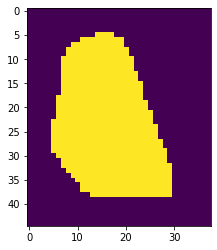

In [256]:
#print(masks[0])
import random
index = int(random.random()*len(masks))
index = 0
print(index)
plt.imshow(masks[index])

In [266]:
np.array(instances['pred_boxes'][0])

array([ 92.872986, 864.0877  , 121.364334, 900.04626 ], dtype=float32)

In [244]:
from skimage.measure import label, regionprops, find_contours, approximate_polygon


In [387]:
instances['pred_boxes'][379]
len(instances['pred_masks'][379])
len(instances['pred_masks'][379][1])

246

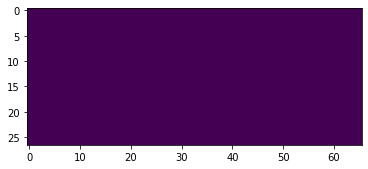

In [382]:
a = 379

plt.imshow(masks[379])

#newcell = cell_object(instances['pred_boxes'][a],instances['pred_masks'][a][0],instances['scores'][a])

In [354]:
newcell = cell_object(instances['pred_boxes'][0],instances['pred_masks'][0][0],instances['scores'][0])

In [396]:
#cell_list = [cell_object(instances['pred_boxes'][i],instances['pred_masks'][i][0],instances['scores'][i]) 
#             for i in range(len(instances['pred_boxes']))]

cell_list = []
for i in range(len(instances['pred_boxes'])):
    cell_list.append(cell_object(instances['pred_boxes'][i],instances['pred_masks'][i],instances['scores'][i]))


In [398]:
len(cell_list)

446

In [395]:
class cell_object:
    #Cell object - takes in a segmentation output and initializes a cell-object with notable properties calculated
    #
    
    def __init__(self, pred_box, polygon, score):
        self.boundingbox = pred_box
        
        if len(polygon) == 1:
            self.polygon = polygon[0]
        else:
            self.polygon = max(polygon, key = len)
        self.score = score
        
        
            
        
        self.mask = self.construct_b_mask(self.polygon,self.boundingbox)
        self.perimeter = self.calc_perimeter(self.polygon)
        
        self.centroid = self.calc_centroid(self.boundingbox)
        
        region_props = self.cell_poly_properties(self.mask)
        
        self.area = region_props[0]
        self.orientation = region_props[1]
        self.majaxis = region_props[2]
        self.minaxis = region_props[3]
        self.circularity = self.calc_circularity(self.area,self.perimeter)
        
    def construct_b_mask(self, polygon, bbox):
        buffer = 5
        width = int(abs(bbox[0]-bbox[2]))+2*buffer
        height = int(abs(bbox[1]-bbox[3]))+2*buffer
        result = np.copy(polygon)
        result[0::2] = np.subtract(result[0::2], min(result[0::2])-buffer)
        result[1::2] = np.subtract(result[1::2], min(result[1::2])-buffer)
        
        img = Image.new('1', (width, height), 0)
        img1 = ImageDraw.Draw(img)
        img1.polygon(result.tolist(), fill = 1, outline = 1)
        return np.array(img)
    
    def calc_centroid(self, bbox):
        return (((bbox[0]+bbox[2])/2).item() , ((bbox[1]+bbox[3])/2).item())
        
    def calc_perimeter(self, polygon):
        perimeter = 0
        for i in range (0,len(polygon)-4,2):
            perimeter += math.sqrt((polygon[i]-polygon[i+2])**2 + (polygon[i+1]-polygon[i+3])**2)
        perimeter += math.sqrt((polygon[0]-polygon[len(polygon)-2])**2 + (polygon[1]-polygon[len(polygon)-1])**2)
        return perimeter
    
    def cell_poly_properties(self, img):
        #takes in an array of a binary mask
        #finds notable cell properties
        #returns a cell array of user defined objects

        img = label(img)
        regions = regionprops(img)
        #print(regions[0].perimeter)
        
        cell_properties = (regions[0].area, regions[0].orientation, regions[0].major_axis_length, 
                           regions[0].minor_axis_length)

        return cell_properties
    
    def calc_circularity(self, area, perimeter):
        return (area * 4 * math.pi / (perimeter**2))
    